# Task 2

In [2]:
import numpy as np


c = np.array([ 2,3,4,5 ])
b = np.array([1,1,1])
A = np.array([[1, 0, 1, 0 ],
              [1, 0, 0, 1],
              [0, 1, 1, 1]])

For the sake of reference, let's solve first the original problem and its linear relaxation with gurobi. We use a [matrix representation of the problem that can also be handled by gurobi](https://www.gurobi.com/resource/gurobi-python-interface-matrix-friendly-modeling-techniques/).

In [54]:

import gurobipy as gp 

def solve_SCP(vtype=gp.GRB.BINARY):
    try:
        # Model
        m = gp.Model("SCP")
        m.setParam(gp.GRB.Param.OutputFlag, 0)
        # Create variables
        x = m.addMVar(shape=c.shape[0], vtype=vtype, name="x")

        # Set objective
        m.setObjective(c @ x, gp.GRB.MINIMIZE)

        # Add constraints
        m.addConstr(A @ x >= b, name="c")

        # Optimize model
        m.optimize()

        print(x.X)
        print('Obj: %g' % m.objVal)

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ": " + str(e))

    except AttributeError:
        print('Encountered an attribute error')

In [16]:
solve_SCP()

[ 1.  1.  0. -0.]
Obj: 5


In [18]:
solve_SCP(vtype=gp.GRB.CONTINUOUS)

[1. 1. 0. 0.]
Obj: 5


### Subtask 1

We relax all three constraints:
$$
\begin{aligned}
z_{LB}=\min &\sum_{j=1}^n c_j x_j - \sum_{i=1}^m\lambda_i\left (\sum_{j=1}^n a_{ij} x_j-1\right )\\
&x_j\in \{0,1\} \qquad j=1,...,n 
\end{aligned}
$$
$$
\begin{aligned}
z_{LB}=\min &\sum_{j=1}^n\left [c_j - \sum_{i=1}^n \lambda_i a_{ij}\right ]x_j + \sum^m_{i=1}\lambda_i\\
&x_j\in \{0,1\} \qquad j=1,...,n 
\end{aligned}
$$

Defining $C_j = [c_j - \sum_{i=1}^m \lambda_i a_{ij}]$ $j=1,...,n$
i.e. $C_j$ is the coefficient of $x_j$ in the objective function of LR we have that LR becomes:
$$
\begin{aligned}
z_{LB}=\min &\sum_j C_jx_j + \sum_{i=1}^m \lambda_i\\
& x_j\in \{0,1\} \qquad j=1,...,n 
\end{aligned}
$$

Now the solution $x_j$ to LR can be found by inspection, namely: 
$$
x_j=
\begin{cases}
 1 &if C_j \leq 0\\
  0 &\text{otherwise}
\end{cases}
$$
with the solution value $z_{LB}$ of LR being given by:
$$z_{LB} = \sum_{j=1}^n C_jx_j + \sum_{i=1}^m\lambda_i$$
where $z_{LB}$ is a lower bound on the optimal solution to the original SCP. 

In [55]:
def solve_lagrangian(lambdas):
    #print("solve with lambda: ",lambdas)
    C = c - lambdas @ A
    x=np.zeros(c.shape[0])
    x[C<=0]=1
    z_LB = np.sum(C@x) + np.sum(lambdas)
    return (x,z_LB)

### Subtask 2

In [31]:
lambdas = np.array([1.5,1.6,2.2])
solve_lagrangian(lambdas)

solve with lambda:  [1.5 1.6 2.2]


(array([1., 0., 0., 0.]), 4.200000000000001)

The solution is not feasiblae for the original problem since the third row is not covered. Hence, it cannot be either optimal.

### Subtask 3

A common fallacy in Lagrangean relaxation is to believe that, if the solution to LR
is feasible for the original problem, then it is also optimal for the original problem.
This is incorrect. 

In [32]:
solve_lagrangian([10,10,10])

solve with lambda:  [10, 10, 10]


(array([1., 1., 1., 1.]), -26.0)

The solution is feasible but not optimal for the original problem, indeed substituting $x$ in the objective function of the original problem we obtain a value of 14, which is not the optimal value (we know that the optimal value is 5).

A solution $x$ to a Lagrangean lower bound program is only optimal for the
original problem if:

1. $x$ is feasible for the original problem; and

2. $cx = [cX + \lambda(b - AX)]$ i.e. $\lambda(b - Ax) = 0$

If we are relaxing equality
constraints ($Ax=b$) then any solution to the Lagrangean lower bound program which is
feasible for the original problem automatically satisfies both 1. and 2. above and so is
optimal. But with inequality constraints we can have 1. without 2.

### Subtask 4

We now set out to find the value of $\vec \lambda$ that yield the best lower bound from the Lagrangian lower bound problem. That is, we solve the Lagrangian dual problem. 
Note that the text writes the update of $\lambda$ as:
$$\lambda_i=\max\{\lambda_i+\theta \lambda_i,0\} \text{ for } i=1,..,m$$
while in the slides we write:
$$\lambda_i=\max\{\lambda_i-\theta \lambda_i,0\} \text{ for } i=1,..,m$$
The first form is for a maximization problem, as is the case here, while the second for a minimization problem.

We will need to calculate an upper bound. For this we design an heuristic procedure that can also be used to derive a feasible solution for the original problem from a solution for the LR problem.

In [46]:
def heuristic_sol(x):
    # inefficient implementation
    x_h=np.copy(x)
    uncovered = A @ x_h - b < 0
    while np.any(uncovered):
        i = np.where(uncovered)[0][0]
        potential=[j for j in range(A.shape[1]) if A[i,j] > 0 and x_h[j]<1]
        x_h[potential[np.argmin(c[potential])]]=1
        uncovered = A @ x_h - b < 0
    z_UB = c @ x_h
    return x_h, z_UB

In [49]:
x_h, z_UB =heuristic_sol(np.array([0,0,0,0]))
x_h, z_UB
np.array([1,2,3])**2

array([1, 4, 9])

Here the solution found is already optimal.

In [195]:
import math

def subgradient_iteration(lambdas, z_UB, epsilon=0.1, mu=2):
    x, z_LR = solve_lagrangian(lambdas)
    subgradient = b - A @ x
    if np.linalg.norm(subgradient)<0.002:
        return x, z_LR, subgradient, lambdas
    theta = mu * ( z_UB - z_LR )/(np.sum(subgradient**2))
    for i in range(lambdas.shape[0]):
        if (np.abs(subgradient[i])>epsilon):                
            lambdas[i] = max(lambdas[i] + theta * subgradient[i], 0)
    print(f"subgradient: {subgradient}, step: {subgradient*theta}, lambdas: {lambdas}")
    return x, z_LR, subgradient, lambdas

Let's try one single iteration of the subgradient optimization algorithm so that we can check the calculations by hand:

In [196]:
subgradient_iteration(np.array([1.5,1.6,2.2]),6)

subgradient: [0. 0. 1.], step: [0.  0.  3.6], lambdas: [1.5 1.6 5.8]


(array([1., 0., 0., 0.]),
 4.200000000000001,
 array([0., 0., 1.]),
 array([1.5, 1.6, 5.8]))

The iterative procedure is given below

In [204]:
%matplotlib inline
import matplotlib.pyplot as plt

def solve_lagrangian_dual(UB=math.inf, lambdas=np.zeros(A.shape[0],dtype='float'), mu=2, iterations=10):
    z_LR=np.zeros(iterations)
    z_LB=np.zeros(iterations)
    z_HR=np.zeros(iterations,dtype='float')
    z_UB=np.zeros(iterations+1,dtype='float')
    _lambdas = [lambdas]
    z_LB[-1]=-math.inf #float('-inf')
    if UB == solve_lagrangian_dual.__defaults__[0]:
        z_UB[0] = heuristic_sol(np.zeros(c.shape[0]))[1]
    else:
        z_UB[0]=UB
    for t in range(iterations):
        #print(_lambdas)
        x, z_LR[t], subgradient, lambdas = subgradient_iteration(lambdas,z_UB[t])
        if np.linalg.norm(subgradient)<0.002:
            iterations=t
            break
        z_HR[t] = heuristic_sol(x)[1]
        #print((z_LR[t],z_LB[t-1]))
        z_LB[t] = max(z_LR[t],z_LB[t-1])
        z_UB[t+1] = min(z_HR[t],z_UB[t])
        _lambdas.append(lambdas.copy())
        if t % math.ceil(iterations/2) == 0:
            print("mu halved")
            mu=mu/2
    
    #print(_lambdas)
    #plt.subplot(3, 1, 1)
    plt.plot(range(iterations), z_LR[:iterations], marker='o',color='blue',label="z_LR")
    plt.plot(range(iterations), z_LB[:iterations], marker='o',color='red',label="z_LB")
    plt.plot(range(iterations), z_UB[:iterations], marker='o',color='green',label="z_UB")
    plt.plot(range(iterations), z_HR[:iterations], marker='o',color='magenta',label="z_HR")
    plt.ylabel('z_LR')
    plt.xlabel('iteration')
    plt.legend()
    plt.show()

    #plt.subplot(3, 1, 1)
    plt.plot(range(iterations), [x[0] for x in _lambdas[:-1]], 'o-')
    plt.plot(range(iterations), [x[1] for x in _lambdas[:-1]], 'o-')
    plt.plot(range(iterations), [x[2] for x in _lambdas[:-1]], 'o-')
    plt.xlabel('iteration')
    plt.ylabel('lambdas')
    plt.show()

subgradient: [0. 0. 1.], step: [0. 0. 6.], lambdas: [1. 1. 7.]
mu halved
subgradient: [-1. -1. -2.], step: [-2.33333333 -2.33333333 -4.66666667], lambdas: [0.         0.         2.33333333]
subgradient: [1. 1. 1.], step: [1.77777778 1.77777778 1.77777778], lambdas: [1.77777778 1.77777778 4.11111111]
subgradient: [-1. -1. -2.], step: [-0.92592593 -0.92592593 -1.85185185], lambdas: [0.85185185 0.85185185 2.25925926]
subgradient: [1. 1. 1.], step: [0.69135802 0.69135802 0.69135802], lambdas: [1.54320988 1.54320988 2.95061728]
subgradient: [-1.  0.  0.], step: [-1.08641975  0.          0.        ], lambdas: [0.45679012 1.54320988 2.95061728]
mu halved
subgradient: [1. 1. 1.], step: [0.03292181 0.03292181 0.03292181], lambdas: [0.48971193 1.57613169 2.98353909]
subgradient: [0. 0. 1.], step: [0.         0.         0.03292181], lambdas: [0.48971193 1.57613169 3.01646091]


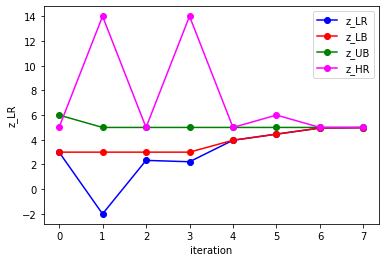

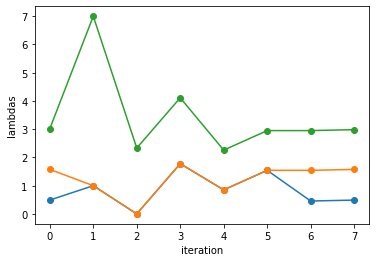

In [205]:
#max(0.0, -math.inf)
solve_lagrangian_dual(UB=6,lambdas=np.array([1.,1.,1.]),mu=1)

After some tuning for the initial parameters we get the desired outcome: the Lagrangian Dual converges towards an maximum that for this problem corresponds to the optimal solution of the original problem. Note that this is a lucky case. Indeed, there are two conditions that appear here:
- the lagrangian problem has the *integrality property* and hence we expect z_LD=z_LP (which is not necessarily a good case for an integer problem because we cannot improve the LP bound)  
- the lagrangina relaxation is integral. Hence, solving the Lagrangian dual we solve the original problem.
We have therefore solved the problem without having to use an LP solver and branch and bound.

# Task 3 (Not Yet Finished)

We consider the following problem (Fisher M., [An Applications Oriented
Guide to Lagrangian Relaxation](http://www.cs.uleth.ca/~benkoczi/OR/read/lagrange-relax-introduct-fisher85.pdf) Interfaces, 15:2, 1985):

$$
\begin{array}{lllll}
 z_P=&\text{max} &16x_1+10x_2+4x_4\\
&\text{s.t.}&8x_1+2x_2+x_3+x_4\leq 10\\
&&x_1+x_2\leq 1\\
&&x_3+x_4\leq 1\\
&&0\leq x\leq 1 \qquad \text{and integer}
\end{array}
$$

There are three major questions to design a Lagrangian-relaxation-based system:
    a. which constraints should be relaxaed
    b. how to compute good multipliers $\lambda$
    c. how to deduce a good feasible solution to the original problem, given a solution to the Lagrangian relaxation problem.

The answers are:
    a. those whose relaxation makes the problem significantly easy but not too easy
    b. subgradient optimization procedure
    c. problem specific heuristics


## Subtask 2.1
If we relax the first constraint with multiplier $\lambda\geq 0$ the corresponding Lagrangian relaxation problem becomes:

$$
\begin{array}{lllll}
 z_P=&\text{max} &(16-8\lambda)x_1+(10-2\lambda)x_2+(0-\lambda)x_3+(4-4\lambda)x_4+10\lambda\\
&\text{s.t.}&x_1+x_2\leq 1\\
&&x_3+x_4\leq 1\\
&&0\leq x\leq 1 \qquad \text{and integer}
\end{array}
$$


For a given $\lambda$ we could solve the problem by inspection: 
- between $x_1$ and $x_2$ set to 1 the variable with the largest cost coefficient in the objective function; 
- between $x_1$ and $x_2$ set to 1 the variable with the largest cost coefficient in the objective function.
However let's use the SCIP procedure developed above.